In [1]:
#import nbimporter
import pickle
import zipfile
import datetime
import string
import glob
import math
import os
import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection
import traceback
import kagglehub
#assert tf.test.is_gpu_available()
import random
import string
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
import PIL
import pickle
from PIL import Image,ImageOps
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import gc
from PIL import Image,ImageOps

In [2]:
from tensorflow.keras.utils import to_categorical

In [3]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [36]:
class DataProcessor:
    def normalize_coordinates(self, coords, original_width, original_height):
        coords = np.array(coords, dtype='float32')
        x_coords = coords[::2]  # Coordenadas x
        y_coords = coords[1::2]  # Coordenadas y
        x_coords /= original_width
        y_coords /= original_height
        normalized_coords = np.concatenate([x_coords, y_coords], axis=-1)
        return normalized_coords
    
    @staticmethod
    def load_and_preprocess_image(image_path, label_class, coords):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)

        image = tf.image.resize(image, [224, 224])
        image = preprocess_input(image)

        label_class = tf.cast(label_class, tf.float32)
        cast_coords = tf.cast(coords, tf.float32)
        return image, {'class_output': label_class, 'bbox_output': cast_coords}

    def create_dataset(self, image_paths, labels_one_hot, coords_normalized, batch_size, shuffle=False):
        image_paths_tensor = tf.constant(image_paths)
        labels_tensor = tf.constant(labels_one_hot)
        coords_tensor = tf.constant(coords_normalized)
        dataset = tf.data.Dataset.from_tensor_slices((image_paths_tensor, labels_tensor, coords_tensor))
        dataset = dataset.map(self.load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        if shuffle:
            dataset = dataset.shuffle(buffer_size=1000)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset


# Cargar dataset

In [5]:
char_coordinates_images_path = kagglehub.dataset_download('gabrielguz/char-coordinates-images')

In [7]:
def load_dataset(dataset_name):
    # Define the paths to the images and labels
    images_dir = os.path.join(dataset_name, 'images')
    labels_path = os.path.join(dataset_name, 'labels.pkl')

    # Load the labels from the pickle file
    with open(labels_path, 'rb') as f:
        labels = pickle.load(f)

    # Get a sorted list of image filenames
    image_files = sorted(os.listdir(images_dir), key=lambda x: int(x.split('_')[1].split('.')[0]))

    # Load the images
    images = []
    for image_file in image_files:
        image_path = os.path.join(images_dir, image_file)
        image = Image.open(image_path)
        images.append(image)

    return images, labels

In [8]:
char_coordinates_images_path='/kaggle/input/char-coordinates-images/content/dataset_abc'
data, labels = load_dataset(char_coordinates_images_path)
print(f'Number of images: {len(data)}')
print(f'Number of labels: {len(labels)}')

Number of images: 30873
Number of labels: 30873


In [9]:

num_samples = len(data)
indices = np.arange(num_samples)
np.random.shuffle(indices)

# Randomizo
data = [data[i] for i in indices]
labels = [labels[i] for i in indices]

In [10]:
num_samples = len(data)
data = data[0:len(data)//2]
labels= labels[ 0:len(labels)//2]

In [11]:
num_samples = len(data)
train_size = int(0.7 * num_samples)
val_size = int(0.2 * num_samples)
test_size = num_samples - train_size - val_size  

In [12]:
image_sizes=(data[0].size)

In [42]:
print(image_sizes)

(244, 244)


In [13]:
# Conjunto de entrenamiento
data_train = data[:train_size]
labels_train = labels[:train_size]

# Conjunto de validación
data_val = data[train_size:train_size + val_size]
labels_val = labels[train_size:train_size + val_size]

# Conjunto de prueba
data_test = data[train_size + val_size:]
labels_test = labels[train_size + val_size:]

In [14]:
print(f"Número de tamaño de entrenamiento: {train_size}\n")
print(f"Número de tamaño de validación: {val_size}\n")
print(f"Número de tamaño de prueba: {test_size}\n")
print(f"Número de imágenes de entrenamiento: {len(data_train)}\n")
print(f"Número de imágenes de validación: {len(data_val)}\n")
print(f"Número de imágenes de prueba: {len(data_test)}\n")

Número de tamaño de entrenamiento: 10805

Número de tamaño de validación: 3087

Número de tamaño de prueba: 1544

Número de imágenes de entrenamiento: 10805

Número de imágenes de validación: 3087

Número de imágenes de prueba: 1544



In [15]:
def verificar_data_no_nulo(a, b, c,d,e,f):
    if a == 0 or b == 0 or c == 0 or (a!=d) or (b!=e) or (c!=f):
        raise ValueError("Error: Una o más variables son cero")

In [16]:
verificar_data_no_nulo(len(data_test),len(data_train),len(data_val),len(labels_test),len(labels_train),len(labels_val))

In [17]:

train_image_dir = 'train_images'
val_image_dir = 'val_images'
test_image_dir = 'test_images'

os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)

In [18]:
# Guardar imágenes y obtener rutas
def save_images(data_subset, image_dir):
    image_paths = []
    for idx, img in enumerate(data_subset):
        image_path = os.path.join(image_dir, f'image_{idx}.png')
        img.save(image_path)
        image_paths.append(image_path)
    return image_paths

train_image_paths = save_images(data_train, train_image_dir)
val_image_paths = save_images(data_val, val_image_dir)
test_image_paths = save_images(data_test, test_image_dir)


In [19]:
def process_coords(labels):
    labels_class = [label[0] for label in labels]
    labels_coords = [label[1] for label in labels]
    return labels_class,labels_coords

In [20]:
labels_train_class,labels_train_coords=process_coords(labels_train)
labels_val_class,labels_val_coords=process_coords(labels_val)
labels_test_class,labels_test_coords=process_coords(labels_test)

In [15]:
# #Nuevo
# # Paso 5: Preparar las etiquetas
# labels_train_class = [label[0] for label in labels_train]
# labels_val_class = [label[0] for label in labels_val]
# labels_test_coords = [label[0] for label in labels_test]

# # Extraer las coordenadas
# labels_train_coords = [label[1] for label in labels_train]
# labels_val_coords = [label[1] for label in labels_val]
# labels_test_coords = [label[1] for label in labels_test]

In [21]:
label_encoder = LabelEncoder()
labels_all_classes = labels_train_class + labels_val_class + labels_test_class
labels_encoded = label_encoder.fit_transform(labels_all_classes)
num_classes = len(label_encoder.classes_)

# Dividir las etiquetas codificadas
labels_train_encoded = labels_encoded[:train_size]
labels_val_encoded = labels_encoded[train_size:train_size + val_size]
labels_test_encoded = labels_encoded[train_size + val_size:]

# Convertir a one-hot encoding
labels_train_one_hot = to_categorical(labels_train_encoded, num_classes=num_classes)
labels_val_one_hot = to_categorical(labels_val_encoded, num_classes=num_classes)
labels_test_one_hot = to_categorical(labels_test_encoded, num_classes=num_classes)

In [22]:
print(f"Número de imágenes de entrenamiento: {len(data_train)}")
print(f"Número de etiquetas de clase de entrenamiento: {len(labels_train_one_hot)}")
print(f"Número de coordenadas de entrenamiento: {len(labels_train_coords)}")

Número de imágenes de entrenamiento: 10805
Número de etiquetas de clase de entrenamiento: 10805
Número de coordenadas de entrenamiento: 10805


In [44]:
# def create_dataset(image_paths, labels_one_hot, coords_normalized, shuffle=False):
#     image_paths_tensor = tf.constant(image_paths)
#     labels_tensor = tf.constant(labels_one_hot)
#     coords_tensor = tf.constant(coords_normalized)
#     dataset = tf.data.Dataset.from_tensor_slices((image_paths_tensor, labels_tensor, coords_tensor))
#     dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
#     if shuffle:
#         dataset = dataset.shuffle(buffer_size=1000)
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.prefetch(tf.data.AUTOTUNE)
#     return dataset


# def load_and_preprocess_image(image_path, label_class, coords):
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_png(image, channels=3)

#     image = tf.image.resize(image, [224, 224])
#     image = preprocess_input(image)

#     label_class = tf.cast(label_class, tf.float32)
#     coords = tf.cast(coords, tf.float32)
#     return image, {'class_output': label_class, 'bbox_output': coords}


In [19]:
# def normalize_coordinates(coords, original_width, original_height):
#     coords = np.array(coords, dtype='float32')
#     x_coords = coords[::2]  # Coordenadas x
#     y_coords = coords[1::2]  # Coordenadas y
#     x_coords /= original_width
#     y_coords /= original_height
#     normalized_coords = np.concatenate([x_coords, y_coords], axis=-1)
#     return normalized_coords

In [37]:
data_processor = DataProcessor()

In [28]:

labels_train_coords_normalized = [data_processor.normalize_coordinates(coords, image_sizes[0],image_sizes[1]) for coords in labels_train_coords]
labels_val_coords_normalized = [data_processor.normalize_coordinates(coords, image_sizes[0],image_sizes[1]) for coords in labels_val_coords]
labels_test_coords_normalized = [data_processor.normalize_coordinates(coords, image_sizes[0],image_sizes[1]) for coords in labels_test_coords]

In [29]:
batch_size=64

In [38]:
train_dataset = data_processor.create_dataset(train_image_paths, labels_train_one_hot, labels_train_coords_normalized,batch_size, shuffle=True)
val_dataset = data_processor.create_dataset(val_image_paths, labels_val_one_hot, labels_val_coords_normalized,batch_size)
test_dataset = data_processor.create_dataset(test_image_paths, labels_test_one_hot, labels_test_coords_normalized,batch_size)

# DEFINO EL MODELO

In [39]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np

# Cargar VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [40]:
from tensorflow.keras.layers import GlobalAveragePooling2D

ENTRENO PARA LOCALIZACIÓN
Ignoro class_output

In [41]:
for layer in base_model.layers:
    layer.trainable = False # Congelar las capas


base_output=base_model.output

# Rama de localización
x_loc = GlobalAveragePooling2D()(base_output)
x_loc = layers.Dense(512)(x_loc)
x_loc = layers.Activation('relu')(x_loc)
x_loc = layers.BatchNormalization()(x_loc)
x_loc = layers.Dropout(0.2)(x_loc)

x_loc = layers.Dense(256)(x_loc)
x_loc = layers.BatchNormalization()(x_loc)
x_loc = layers.Activation('relu')(x_loc)
x_loc = layers.Dropout(0.2)(x_loc)

x_loc = layers.Dense(128)(x_loc)
x_loc = layers.BatchNormalization()(x_loc)
x_loc = layers.Activation('relu')(x_loc)

bbox_output = layers.Dense(8, activation='sigmoid', name='bbox_output')(x_loc)

# Rama de clasificación
x_class = GlobalAveragePooling2D()(base_output)
x_class = layers.Dense(512)(x_class)
x_class = layers.Activation('relu')(x_class)
x_class = layers.BatchNormalization()(x_class)
x_class = layers.Dropout(0.5)(x_class)

x_class = layers.Dense(256)(x_class)
x_class = layers.Activation('relu')(x_class)
x_class = layers.BatchNormalization()(x_class)
x_class = layers.Dropout(0.3)(x_class)

x_class = layers.Dense(128)(x_class)
x_class = layers.BatchNormalization()(x_class)
x_class = layers.Activation('relu')(x_class)
x_class = layers.Dropout(0.2)(x_class)

class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(x_class)

# Crear el modelo
model = models.Model(inputs=base_model.input, outputs=[bbox_output, class_output])

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

In [44]:
for layer in model.layers:
    if 'class' in layer.name:
        layer.trainable = False

# Compilar el modelo para localización
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'bbox_output': 'mean_squared_error', 'class_output': 'categorical_crossentropy'},
    loss_weights={'bbox_output': 1.0, 'class_output': 0.0},
    metrics={'bbox_output': 'mae'}
)

In [45]:
for layer in model.layers:
    if 'class' in layer.name:
        layer.trainable = False

# Compilar el modelo para localización
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'bbox_output': 'mean_squared_error', 'class_output': 'categorical_crossentropy'},
    loss_weights={'bbox_output': 1.0, 'class_output': 0.0},
    metrics={'bbox_output': 'mae'}
)

# Entrenar el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_loc = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/20


I0000 00:00:1733451712.667464     329 service.cc:145] XLA service 0x780b040254e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733451712.667553     329 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733451712.667560     329 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733451751.736210     329 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - bbox_output_mae: 0.1002 - loss: 0.0179

I0000 00:00:1733451854.890081     455 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot', 4 bytes spill stores, 4 bytes spill loads



169/169 ━━━━━━━━━━━━━━━━━━━━ 161s 687ms/step - bbox_output_mae: 0.1001 - loss: 0.0179 - val_bbox_output_mae: 0.0591 - val_loss: 0.0060
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 374ms/step - bbox_output_mae: 0.0469 - loss: 0.0040 - val_bbox_output_mae: 0.0413 - val_loss: 0.0034
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 377ms/step - bbox_output_mae: 0.0415 - loss: 0.0034 - val_bbox_output_mae: 0.0380 - val_loss: 0.0031
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 377ms/step - bbox_output_mae: 0.0389 - loss: 0.0030 - val_bbox_output_mae: 0.0377 - val_loss: 0.0031
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 376ms/step - bbox_output_mae: 0.0377 - loss: 0.0029 - val_bbox_output_mae: 0.0371 - val_loss: 0.0030
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 378ms/step - bbox_output_mae: 0.0373 - loss: 0.0028 - val_bbox_output_mae: 0.0368 - val_loss: 0.0029
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 377ms/step - bbox_output_mae: 0.0363 - loss: 0.0027 - val_bbox_output_mae: 0.0369 - val_loss: 0.

ENTRENO PARA CLASIFICACIÓN
Ignoro bbox_output

In [46]:
for layer in model.layers:
    if 'bbox' in layer.name:
        layer.trainable = False
    elif 'class' in layer.name:
        layer.trainable = True

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'bbox_output': 'mean_squared_error', 'class_output': 'categorical_crossentropy'},
    loss_weights={'bbox_output': 0.0, 'class_output': 1.0},
    metrics={'class_output': 'accuracy'}
)
history_class = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)


Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 90s 442ms/step - class_output_accuracy: 0.0196 - loss: 4.3678 - val_class_output_accuracy: 0.0489 - val_loss: 3.8505
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 379ms/step - class_output_accuracy: 0.0519 - loss: 3.8496 - val_class_output_accuracy: 0.0790 - val_loss: 3.6019
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 372ms/step - class_output_accuracy: 0.0858 - loss: 3.5885 - val_class_output_accuracy: 0.1173 - val_loss: 3.4270
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 370ms/step - class_output_accuracy: 0.1148 - loss: 3.4047 - val_class_output_accuracy: 0.1412 - val_loss: 3.2930
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 373ms/step - class_output_accuracy: 0.1515 - loss: 3.2479 - val_class_output_accuracy: 0.1649 - val_loss: 3.1648
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 372ms/step - class_output_accuracy: 0.1763 - loss: 3.1016 - val_class_output_accuracy: 0.1772 - val_loss: 3.0826
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 373ms/step - c

FINETUNEO

In [47]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

COMPILACIÓN PREVIA

In [48]:
from tensorflow.keras.optimizers import Adam

# Usar una tasa de aprendizaje baja para el fine-tuning
learning_rate = 1e-5
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss={
        'class_output': 'categorical_crossentropy',
        'bbox_output': 'mean_squared_error'
    },
    loss_weights={
        'class_output': 2.0,
        'bbox_output': 1.0
    },
    metrics={
        'class_output': 'accuracy',
        'bbox_output': 'mae'
    }
)


In [49]:
history_finetune = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

# Paso 4: Evaluar el modelo
bbox_output_mae, loss, class_output_accuracy= model.evaluate(test_dataset)
print(f"Loss total en prueba: {loss}")
print(f" Accuracy: {class_output_accuracy}")
print(f" MAE: {bbox_output_mae}")

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 103s 498ms/step - bbox_output_mae: 0.0310 - class_output_accuracy: 0.3329 - loss: 4.7683 - val_bbox_output_mae: 0.0345 - val_class_output_accuracy: 0.3301 - val_loss: 4.8022
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 73s 421ms/step - bbox_output_mae: 0.0310 - class_output_accuracy: 0.4001 - loss: 4.2768 - val_bbox_output_mae: 0.0348 - val_class_output_accuracy: 0.3547 - val_loss: 4.5317
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 72s 417ms/step - bbox_output_mae: 0.0310 - class_output_accuracy: 0.4310 - loss: 3.9968 - val_bbox_output_mae: 0.0345 - val_class_output_accuracy: 0.3842 - val_loss: 4.3502
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 72s 417ms/step - bbox_output_mae: 0.0306 - class_output_accuracy: 0.4627 - loss: 3.8114 - val_bbox_output_mae: 0.0342 - val_class_output_accuracy: 0.4056 - val_loss: 4.2345
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 72s 418ms/step - bbox_output_mae: 0.0308 - class_output_accuracy: 0.4855 - loss: 3.6464 - val_bbox_output_m

In [50]:

def reverse_preprocess_vgg16(image, original_size):
    """
    Revertir el preprocesamiento aplicado por VGG16.
    
    Args:
        image (numpy.ndarray): Imagen preprocesada con VGG16 (BGR, medios restados).
        original_size: Altura original de la imagen y Ancho original de la imagen.
    
    Returns:
        numpy.ndarray: Imagen en formato RGB, valores en [0, 255], redimensionada al tamaño original.
    """
   
    MEAN_VALUES = np.array([103.939, 116.779, 123.68])
    
    img = image.copy()
    img += MEAN_VALUES
    img = img[..., ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    
   
    img = cv2.resize(img, original_size, interpolation=cv2.INTER_LINEAR)
    
    return img

In [54]:


def visualize_test_predictions(model,test_dataset,im_sizes,num_images_to_process = 10):
    images_processed = 0
    
    for images, labels in test_dataset:
        preds = model.predict(images)
        preds_coords = preds[0]
        preds_classes = preds[1]
    
        for i in range(len(images)):
            if images_processed >= num_images_to_process:
                break  
        
            img = images[i].numpy()
            img = reverse_preprocess_vgg16(img, image_sizes)
        
            coords_true = labels['bbox_output'][i].numpy()
            coords_pred = preds_coords[i]
        
            coords_true_scaled = coords_true.copy()
            coords_true_scaled[:4] *= image_sizes[0]  
            coords_true_scaled[4:] *= image_sizes[1]  

            coords_pred_scaled = coords_pred.copy()
            coords_pred_scaled[:4] *= image_sizes[0] 
            coords_pred_scaled[4:] *= image_sizes[1]

            x_true = coords_true_scaled[:4]
            y_true = coords_true_scaled[4:]
            x_pred = coords_pred_scaled[:4]
            y_pred = coords_pred_scaled[4:]
        
            class_true_idx = np.argmax(labels['class_output'][i].numpy())
            class_pred_idx = np.argmax(preds_classes[i])
            class_true_label = label_encoder.inverse_transform([class_true_idx])[0]
            class_pred_label = label_encoder.inverse_transform([class_pred_idx])[0]
        
            fig, ax = plt.subplots(1)
            ax.imshow(img)
        
            ax.plot(x_true, y_true, 'go-', label='Verdadero')
        
            ax.plot(x_pred, y_pred, 'ro-', label='Predicho')
        
            plt.title(f"Clase real: {class_true_label}, Clase predicha: {class_pred_label}")
            plt.legend()
            plt.show()
        
            images_processed += 1
    
        if images_processed >= num_images_to_process:
            break  

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


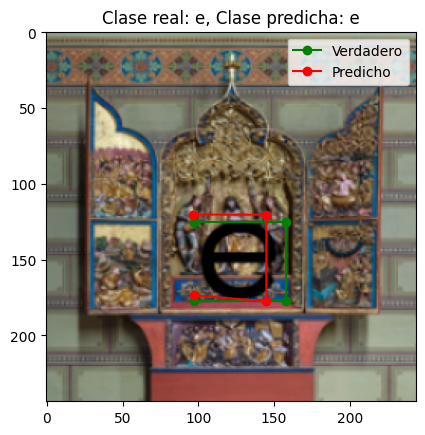

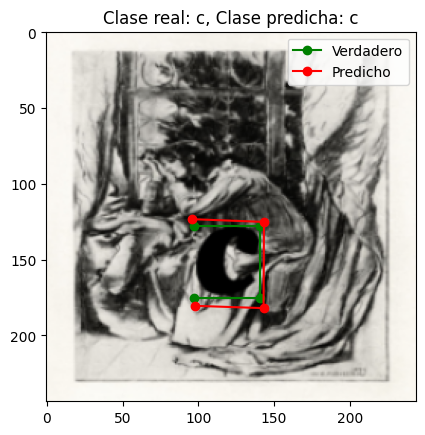

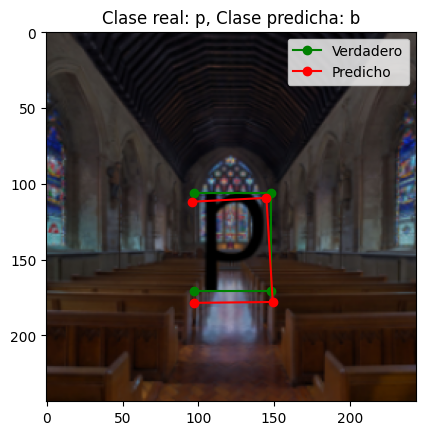

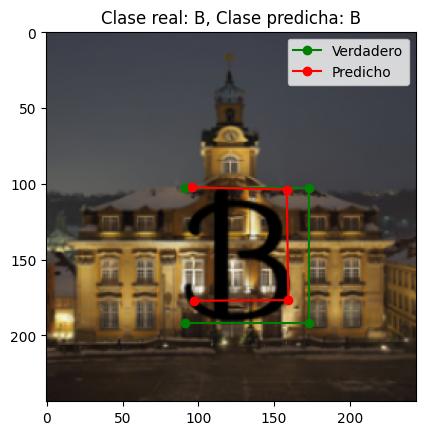

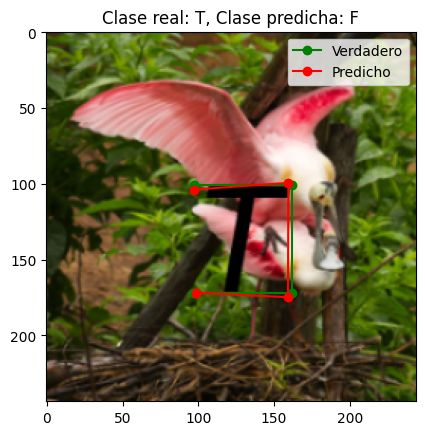

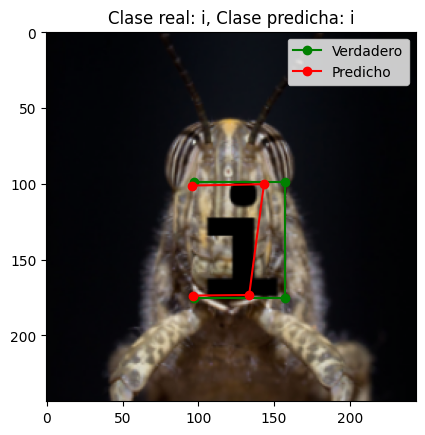

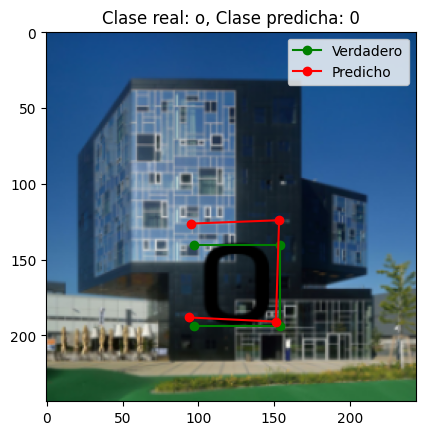

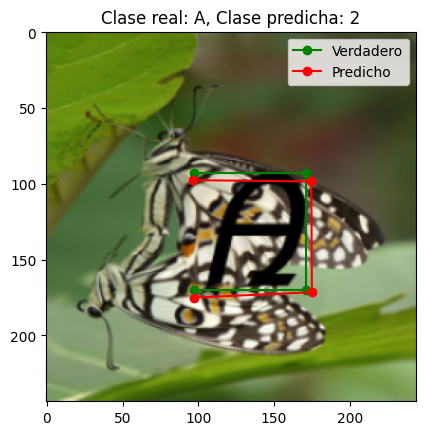

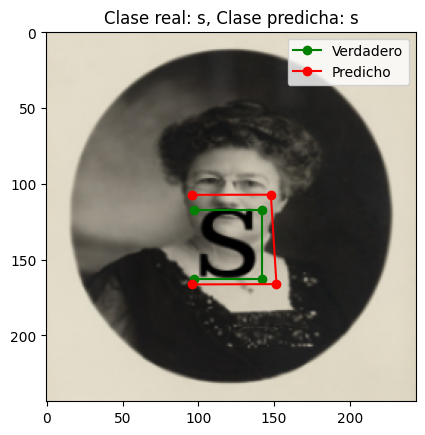

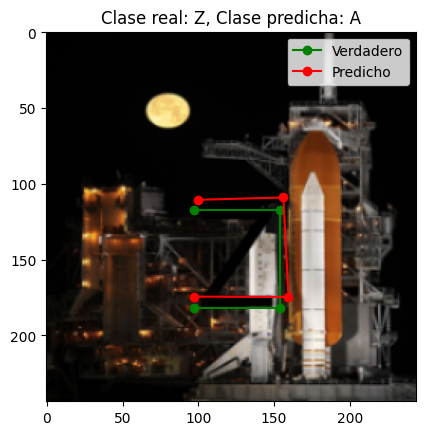

In [55]:
visualize_test_predictions(model,test_dataset,image_sizes)

In [56]:
predictions = model.predict(test_dataset)
preds_classes = predictions[1]

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 334ms/step


In [57]:
y_true = []


for images, labels in test_dataset:
    class_labels = labels['class_output'].numpy()
    class_indices = np.argmax(class_labels, axis=1)
    y_true.extend(class_indices)

y_true = np.array(y_true)

In [58]:
y_pred = np.argmax(preds_classes, axis=1)

In [59]:
from sklearn.metrics import classification_report

class_labels = label_encoder.classes_
report = classification_report(y_true, y_pred, target_names=class_labels)

print(report)

              precision    recall  f1-score   support

           0       0.37      0.35      0.36        20
           1       0.40      0.24      0.30        17
           2       0.52      0.83      0.64        18
           3       0.48      0.58      0.53        26
           4       0.86      0.60      0.71        30
           5       0.79      0.79      0.79        29
           6       0.80      0.70      0.74        23
           7       0.89      0.57      0.69        30
           8       0.75      0.72      0.74        29
           9       0.62      0.45      0.52        29
           A       0.58      0.65      0.61        17
           B       0.81      0.85      0.83        20
           C       0.64      0.64      0.64        25
           D       0.73      0.79      0.76        24
           E       0.51      0.72      0.60        32
           F       0.68      0.63      0.65        27
           G       0.73      0.58      0.65        19
           H       0.72    